## Customers Segmentation based on their Credit Card usage bhaviour

Dataset for this notebook consists of credit card usage behavior of customers with 18 behavioral features. Segmentation of customers can be used to define marketing strategies.


**Content of this Kernel:**
* Data Preprocessing
* Clustering using KMeans
* Interpretation of Clusters
* Visualization of Clusters using PCA

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler#Normalizes the data
from sklearn.cluster import KMeans #Trains a cluster model
from sklearn.decomposition import PCA #Helps build better fit features for the model
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings(action="ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['CC GENERAL.csv']


In [3]:
data= pd.read_csv("../input/CC GENERAL.csv") #Loading the dataset
print(data.shape)
data.head() #Observing a handful of datapoints

(8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Data Preprocessing

#### Descriptive Statistics of Data

In [4]:
data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Seems like data have many outliers!

#### Dealing with Missing Values

In [7]:
data.isnull().sum().sort_values(ascending=False).head()

MINIMUM_PAYMENTS       313
CREDIT_LIMIT             1
TENURE                   0
PURCHASES_FREQUENCY      0
BALANCE                  0
dtype: int64

Imputing these missing values with mean

In [8]:
data.loc[(data['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS']=data['MINIMUM_PAYMENTS'].mean()
data.loc[(data['CREDIT_LIMIT'].isnull()==True),'CREDIT_LIMIT']=data['CREDIT_LIMIT'].mean()

In [9]:
data.isnull().sum().sort_values(ascending=False).head()

TENURE               0
PRC_FULL_PAYMENT     0
BALANCE              0
BALANCE_FREQUENCY    0
PURCHASES            0
dtype: int64


#### Dealing with Outliers

There are just way too many outliers in the dataset, to be dropped.

In [11]:
columns=['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS']

for c in columns:
    
    Range=c+'_RANGE'
    data[Range]=0        
    data.loc[((data[c]>0)&(data[c]<=500)),Range]=1
    data.loc[((data[c]>500)&(data[c]<=1000)),Range]=2
    data.loc[((data[c]>1000)&(data[c]<=3000)),Range]=3
    data.loc[((data[c]>3000)&(data[c]<=5000)),Range]=4
    data.loc[((data[c]>5000)&(data[c]<=10000)),Range]=5
    data.loc[((data[c]>10000)),Range]=6
 

In [8]:
columns=['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 
         'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT']

for c in columns:
    
    Range=c+'_RANGE'
    data[Range]=0
    data.loc[((data[c]>0)&(data[c]<=0.1)),Range]=1
    data.loc[((data[c]>0.1)&(data[c]<=0.2)),Range]=2
    data.loc[((data[c]>0.2)&(data[c]<=0.3)),Range]=3
    data.loc[((data[c]>0.3)&(data[c]<=0.4)),Range]=4
    data.loc[((data[c]>0.4)&(data[c]<=0.5)),Range]=5
    data.loc[((data[c]>0.5)&(data[c]<=0.6)),Range]=6
    data.loc[((data[c]>0.6)&(data[c]<=0.7)),Range]=7
    data.loc[((data[c]>0.7)&(data[c]<=0.8)),Range]=8
    data.loc[((data[c]>0.8)&(data[c]<=0.9)),Range]=9
    data.loc[((data[c]>0.9)&(data[c]<=1.0)),Range]=10
    

In [12]:
columns=['PURCHASES_TRX', 'CASH_ADVANCE_TRX']  

for c in columns:
    
    Range=c+'_RANGE'
    data[Range]=0
    data.loc[((data[c]>0)&(data[c]<=5)),Range]=1
    data.loc[((data[c]>5)&(data[c]<=10)),Range]=2
    data.loc[((data[c]>10)&(data[c]<=15)),Range]=3
    data.loc[((data[c]>15)&(data[c]<=20)),Range]=4
    data.loc[((data[c]>20)&(data[c]<=30)),Range]=5
    data.loc[((data[c]>30)&(data[c]<=50)),Range]=6
    data.loc[((data[c]>50)&(data[c]<=100)),Range]=7
    data.loc[((data[c]>100)),Range]=8

In [14]:
data.drop(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY',  'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT' ], axis=1, inplace=True)

X= np.asarray(data)

KeyError: "['CUST_ID' 'BALANCE' 'BALANCE_FREQUENCY' 'PURCHASES' 'ONEOFF_PURCHASES'\n 'INSTALLMENTS_PURCHASES' 'CASH_ADVANCE' 'PURCHASES_FREQUENCY'\n 'ONEOFF_PURCHASES_FREQUENCY' 'PURCHASES_INSTALLMENTS_FREQUENCY'\n 'CASH_ADVANCE_FREQUENCY' 'CASH_ADVANCE_TRX' 'PURCHASES_TRX'\n 'CREDIT_LIMIT' 'PAYMENTS' 'MINIMUM_PAYMENTS' 'PRC_FULL_PAYMENT'] not found in axis"

# Normalizing input values.

In [15]:
scale = StandardScaler()
X = scale.fit_transform(X)
X.shape

(8950, 11)

## MODELING

#### Clustering using Kmeans

In [16]:
n_clusters=30
cost=[]
for i in range(1,n_clusters):
    kmean= KMeans(i)
    kmean.fit(X)
    cost.append(kmean.inertia_)  

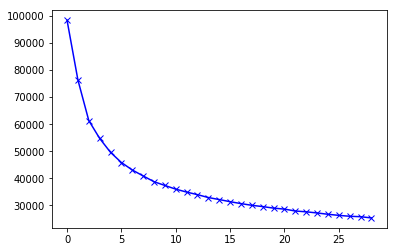

In [17]:
plt.plot(cost, 'bx-')

#### Choosing 6 as the number of clusters 

In [14]:
kmean= KMeans(6)
kmean.fit(X)
labels=kmean.labels_

In [15]:
clusters=pd.concat([data, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

,TENURE,BALANCE_RANGE,PURCHASES_RANGE,ONEOFF_PURCHASES_RANGE,INSTALLMENTS_PURCHASES_RANGE,CASH_ADVANCE_RANGE,CREDIT_LIMIT_RANGE,PAYMENTS_RANGE,MINIMUM_PAYMENTS_RANGE,BALANCE_FREQUENCY_RANGE,PURCHASES_FREQUENCY_RANGE,ONEOFF_PURCHASES_FREQUENCY_RANGE,PURCHASES_INSTALLMENTS_FREQUENCY_RANGE,CASH_ADVANCE_FREQUENCY_RANGE,PRC_FULL_PAYMENT_RANGE,PURCHASES_TRX_RANGE,CASH_ADVANCE_TRX_RANGE,cluster
0,12,1,1,0,1,0,2,1,1,9,2,0,1,0,0,1,0,4
1,12,4,0,0,0,5,5,4,3,10,0,0,0,3,3,0,1,3
2,12,3,2,2,0,0,5,2,2,10,10,10,0,0,0,3,0,1
3,12,3,3,3,0,1,5,0,2,7,1,1,0,1,0,1,1,4
4,12,2,1,1,0,0,3,2,1,10,1,1,0,0,0,1,0,4


## Interpretation of Clusters

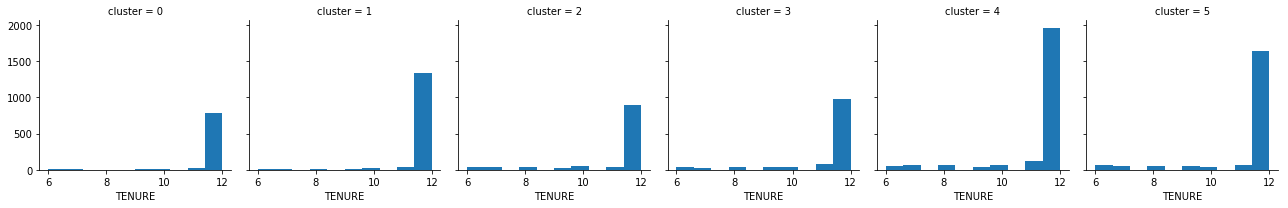

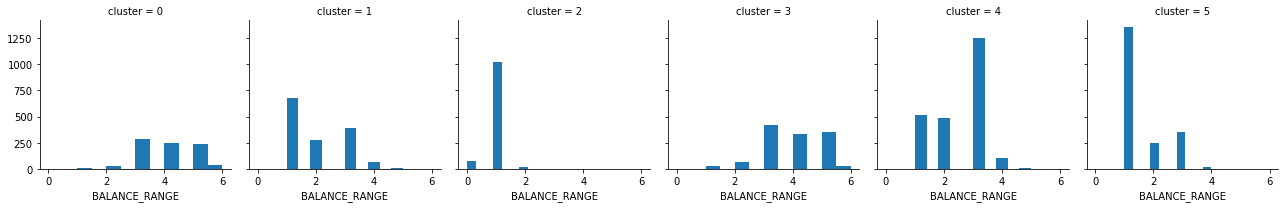

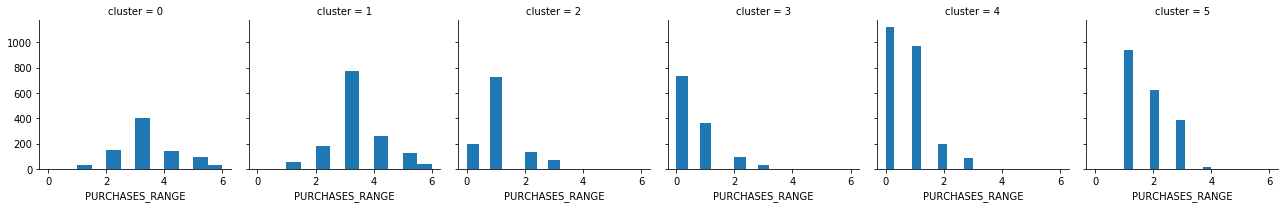

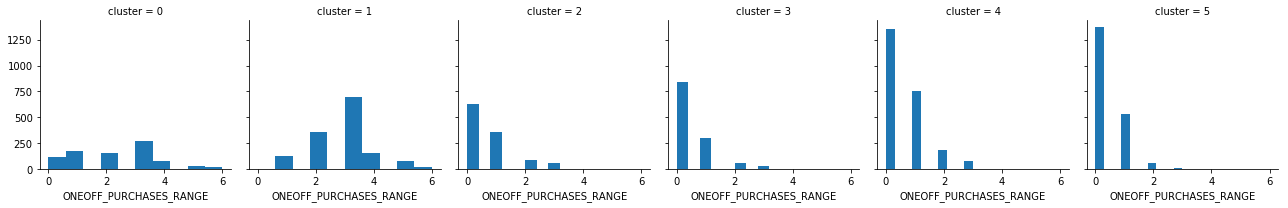

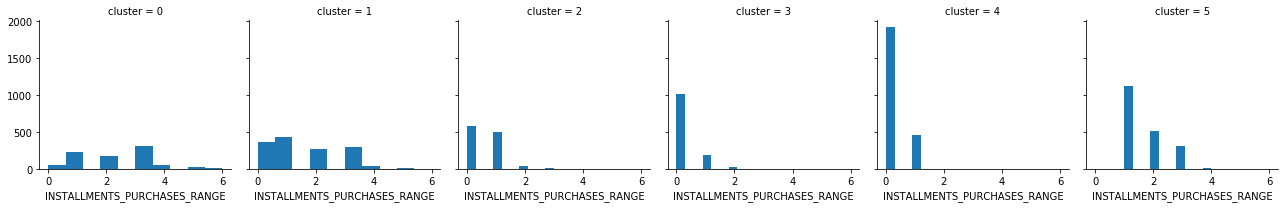

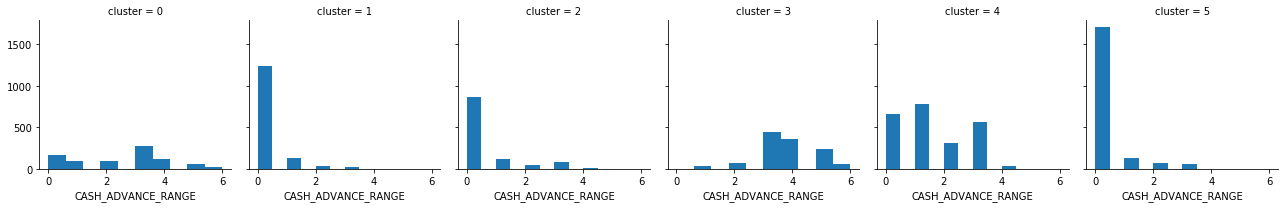

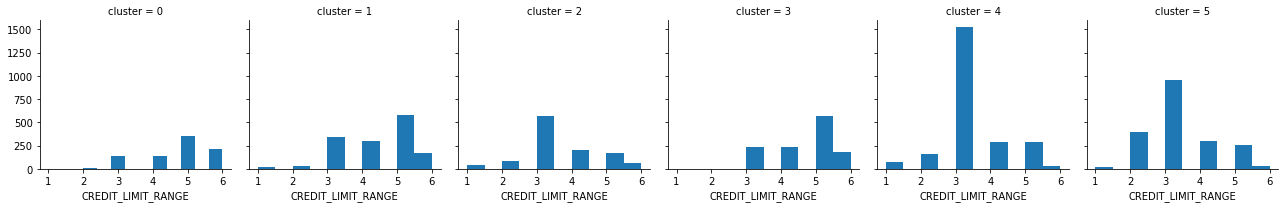

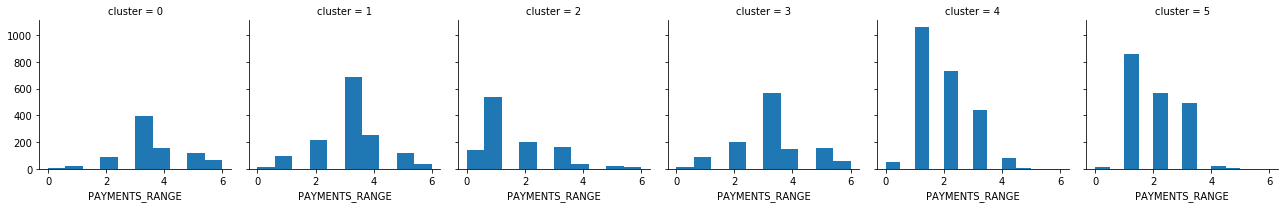

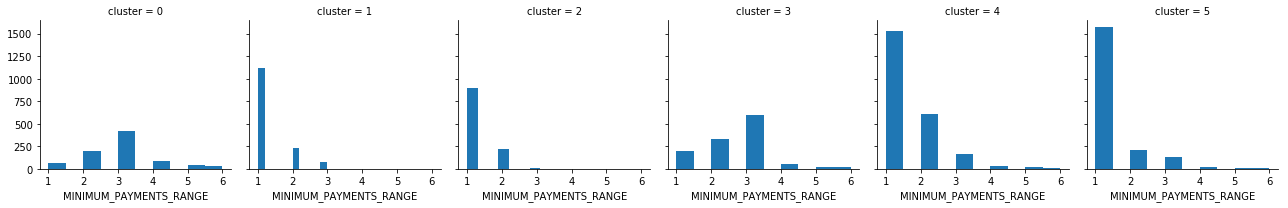

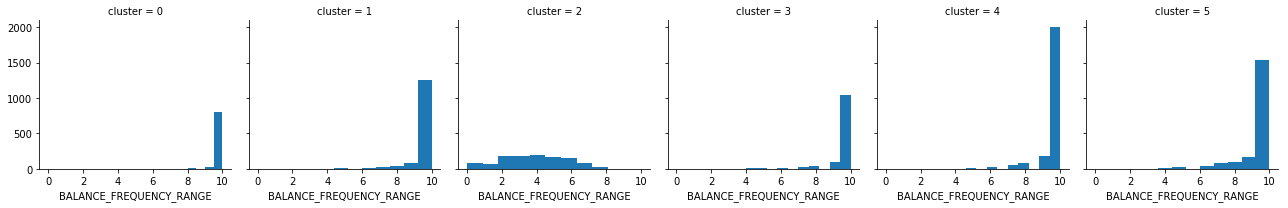

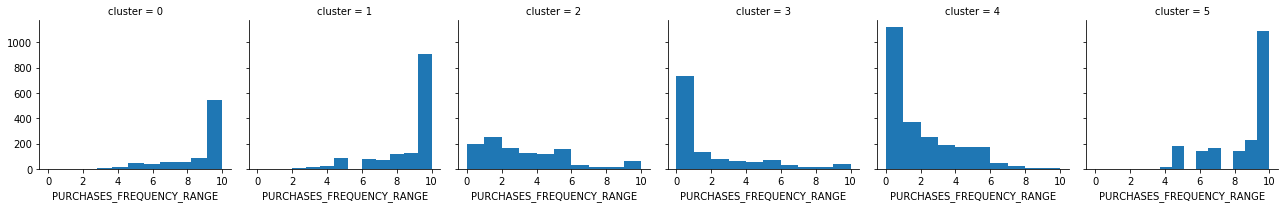

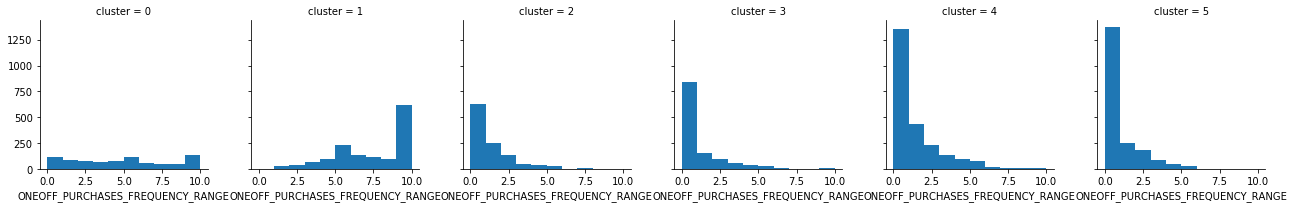

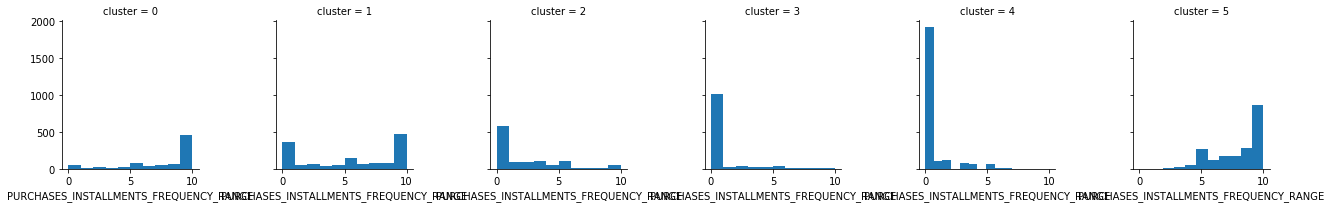

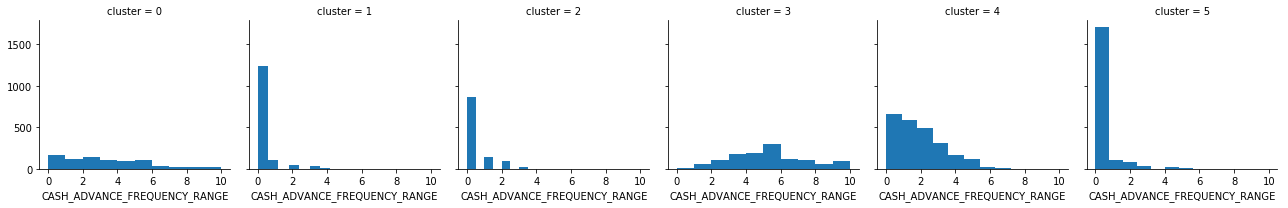

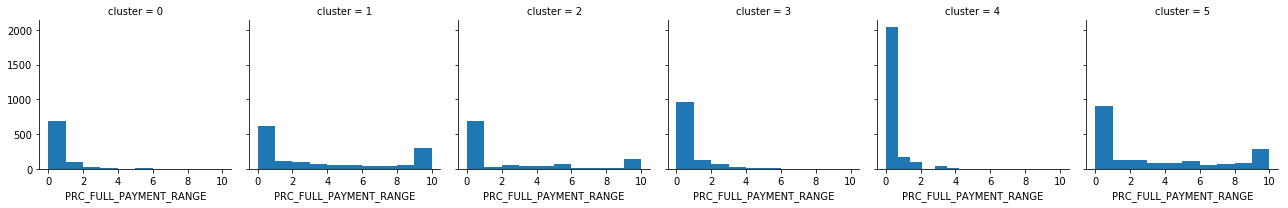

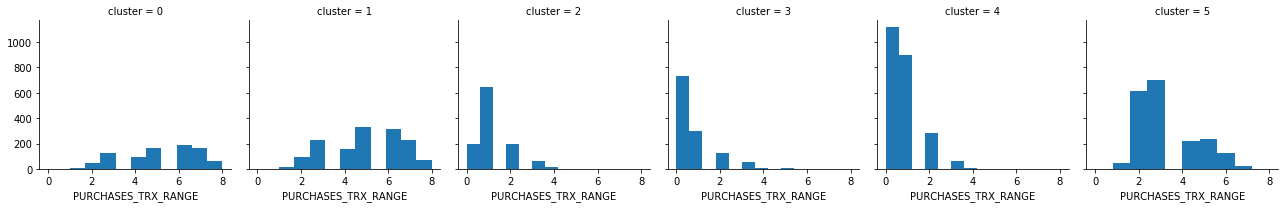

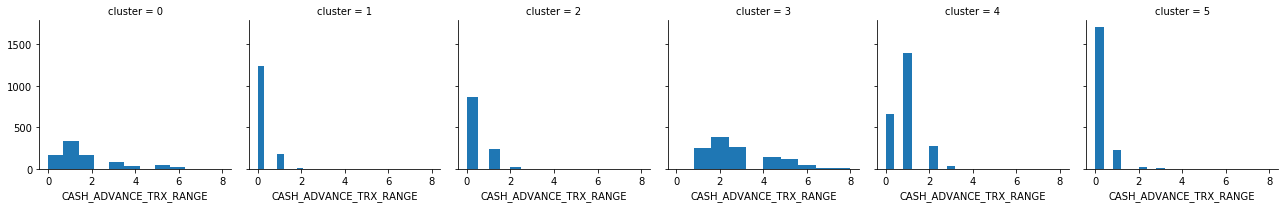

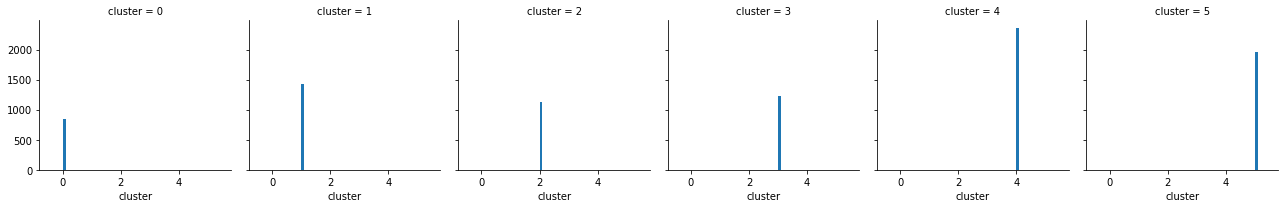

In [16]:
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

* **Cluster0** People with average to high credit limit who make all type of purchases

* **Cluster1** This group has more people with due payments who take advance cash more often

* **Cluster2** Less money spenders with average to high credit limits who purchases mostly in installments 

* **Cluster3** People with high credit limit who take more cash in advance 

* **Cluster4** High spenders with high credit limit who make expensive purchases

* **Cluster5** People who don't spend much money and who have average to high credit limit

(Clsuter number changes when re run)

## Visualization of Clusters

#### Using PCA to transform data to 2 dimensions for visualization

In [17]:
dist = 1 - cosine_similarity(X)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(8950, 2)

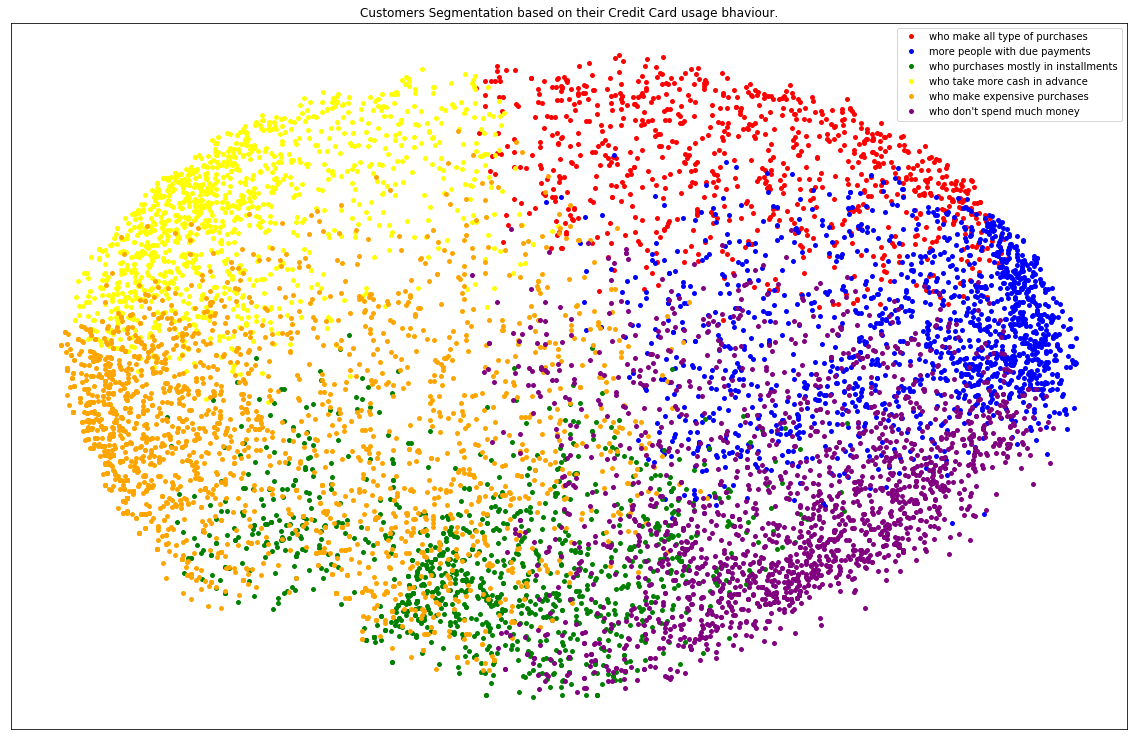

In [18]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5:'purple'}

names = {0: 'who make all type of purchases', 
         1: 'more people with due payments', 
         2: 'who purchases mostly in installments', 
         3: 'who take more cash in advance', 
         4: 'who make expensive purchases',
         5:'who don\'t spend much money'}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage bhaviour.")
plt.show()